In [54]:
import pandas as pd
import numpy as np

In [55]:
df = pd.read_csv("data/course_lead_scoring.csv")
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [56]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [57]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [58]:
# data preparation
categorical = list(df.columns[df.dtypes == 'object'])
categorical

['lead_source', 'industry', 'employment_status', 'location']

In [59]:
numerical = ['number_of_courses_viewed',
    'annual_income',
    'interaction_count',
    'lead_score']
numerical

['number_of_courses_viewed',
 'annual_income',
 'interaction_count',
 'lead_score']

In [60]:
for col in categorical:
    df[col] = df[col].fillna("NA")
    
for col in numerical:
    df[col] = df[col].fillna(0)
    
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [61]:
# data splition
from sklearn.model_selection import train_test_split

train_validation, test = train_test_split(df, test_size=0.2, random_state=1)
train, validation = train_test_split(train_validation, test_size=0.25, random_state=1)
print(len(train), len(validation), len(test))

876 293 293


In [62]:
# Q1: ROC feature importance
from sklearn.metrics import roc_auc_score

y = train.converted.values

for col in numerical:
    fi = roc_auc_score(y, train[col])
    print(col, fi.round(3))

number_of_courses_viewed 0.764
annual_income 0.552
interaction_count 0.738
lead_score 0.614


In [63]:
# Q2: Training the model
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler

# scale numberical features
scaler = StandardScaler()
X_train_num = train[numerical]
X_train_num = scaler.fit_transform(X_train_num)

# one-hot-encoding using DictVectorizer
dv = DictVectorizer(sparse=False)
train_dict = train[categorical].to_dict(orient='records')
X_train_cat = dv.fit_transform(train_dict)

X_train = np.column_stack([X_train_num, X_train_cat])
y_train = train.converted.values

X_validation_num = validation[numerical]
X_validation_num = scaler.transform(X_validation_num)
validation_dict = validation[categorical].to_dict(orient='records')
X_validation_cat = dv.transform(validation_dict)
X_validation = np.column_stack([X_validation_num, X_validation_cat])
y_validation = validation.converted.values

In [64]:
from sklearn.linear_model import LogisticRegression

# model = LogisticRegression(solver='lbfgs', C=1.0, max_iter=2000)
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

model.fit(X_train, y_train)

y_pred = model.predict_proba(X_validation)[:, 1]
auc = roc_auc_score(y_validation, y_pred)
auc.round(3)

np.float64(0.921)

In [65]:
# Q3: precision and recall
# Q4: F1 score

thresholds = np.linspace(0, 1, 101)

scores = []
for t in thresholds:
    y_pred_label = (y_pred >= t).astype(int)
    tp = ((y_pred_label == 1) & (y_validation == 1)).sum()
    fp = ((y_pred_label == 1) & (y_validation == 0)).sum()
    fn = ((y_pred_label == 0) & (y_validation == 1)).sum()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    scores.append((t, precision, recall, f1))
    
df_scores = pd.DataFrame(scores, columns=["Threshold", "Precision", "Recall", "F1"])
df_scores.head(10)

/var/folders/cl/j9k2b3n537bg1fr81hb9b5jh0000gn/T/ipykernel_49933/3432444255.py:12: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


,Threshold,Precision,Recall,F1
0,0.00,0.583618,1.000000,0.737069
1,0.01,0.595819,1.000000,0.746725
2,0.02,0.608541,1.000000,0.756637
3,0.03,0.611511,0.994152,0.757238
4,0.04,0.622711,0.994152,0.765766
5,0.05,0.630597,0.988304,0.769932
6,0.06,0.630597,0.988304,0.769932
7,0.07,0.637736,0.988304,0.775229
8,0.08,0.638783,0.982456,0.774194
9,0.09,0.641221,0.982456,0.775982


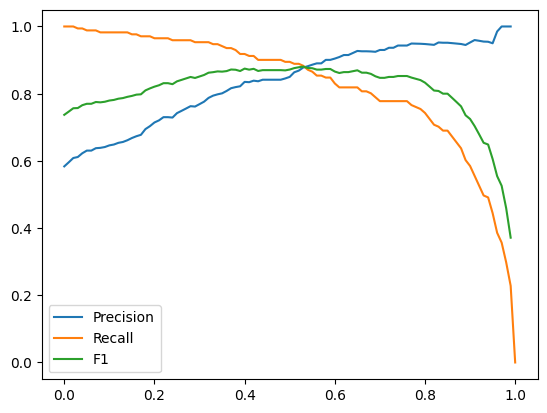

In [66]:
import matplotlib.pyplot as plt

plt.plot(df_scores.Threshold, df_scores.Precision, label="Precision")
plt.plot(df_scores.Threshold, df_scores.Recall, label="Recall")
plt.plot(df_scores.Threshold, df_scores.F1, label="F1")
plt.legend()

In [67]:
df_scores.iloc[df_scores["F1"].argmax()]

Threshold    0.530000
Precision    0.877907
Recall       0.883041
F1           0.880466
Name: 53, dtype: float64

In [77]:
# Q5: 5-fold CV
def train_model(df_train, C=1.0):
    
    # scale numberical features
    sc = StandardScaler()
    X_train_num = df_train[numerical]
    X_train_num = sc.fit_transform(X_train_num)

    # one-hot-encoding using DictVectorizer
    dv = DictVectorizer(sparse=False)
    train_dict = df_train[categorical].to_dict(orient='records')
    X_train_cat = dv.fit_transform(train_dict)

    X_train = np.column_stack([X_train_num, X_train_cat])
    y_train = df_train.converted.values

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return sc, dv, model

sc, dv, model = train_model(train)

def predict(df, sc, dv, model):
    X_num = df[numerical]
    X_num = sc.transform(X_num)
    df_dict = df[categorical].to_dict(orient='records')
    X_cat = dv.transform(df_dict)
    X = np.column_stack([X_num, X_cat])
    y_pred = model.predict_proba(X)[:, 1]
    return y_pred

y_pred = predict(validation, sc, dv, model)
auc = roc_auc_score(y_validation, y_pred)
auc.round(3)

np.float64(0.921)

In [84]:
from tqdm.auto import tqdm
from sklearn.model_selection import KFold

n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
scores = []

for i, (train_idx, val_idx) in enumerate(tqdm(kfold.split(train_validation), total=n_splits, desc="Cross-validation"), 1):
    df_train = train_validation.iloc[train_idx]
    df_val = train_validation.iloc[val_idx]

    y_train = df_train.converted.values
    y_val = df_val.converted.values

    sc, dv, model = train_model(df_train)
    y_pred = predict(df_val, sc, dv, model)
    # print(y_val.shape, y_pred.shape)
    auc = roc_auc_score(y_val, y_pred)
    print(f"Fold {i + 1}: {auc:.3f}")
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

Cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]

Fold 2: 0.921
Fold 3: 0.932
Fold 4: 0.907
Fold 5: 0.911
Fold 6: 0.932
0.921 +- 0.010


In [85]:
# Q6: hyperparameter tuning

for C in tqdm([0.000001, 0.001, 1], desc="Hyper Tuning"):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = []

    i = 1
    for train_idx, val_idx in kfold.split(train_validation):
        df_train = train_validation.iloc[train_idx]
        df_val = train_validation.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        sc, dv, model = train_model(df_train, C=C)
        y_pred = predict(df_val, sc, dv, model)
        # print(y_val.shape, y_pred.shape)
        auc = roc_auc_score(y_val, y_pred)
        print(f"Fold {i}: {auc:.3f}")
        i += 1
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

Hyper Tuning:   0%|          | 0/3 [00:00<?, ?it/s]

Fold 1: 0.899
Fold 2: 0.905
Fold 3: 0.896
Fold 4: 0.889
Fold 5: 0.927
C=1e-06 0.903 +- 0.013
Fold 1: 0.901
Fold 2: 0.909
Fold 3: 0.896
Fold 4: 0.891
Fold 5: 0.929
C=0.001 0.905 +- 0.013
Fold 1: 0.921
Fold 2: 0.932
Fold 3: 0.907
Fold 4: 0.911
Fold 5: 0.932
C=1 0.921 +- 0.010
